In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import IPython.display as display
import time

from concurrent.futures import ThreadPoolExecutor

%matplotlib inline

In [2]:
physical_device = tf.config.list_physical_devices('GPU')[0]
try:
  tf.config.experimental.set_memory_growth(physical_device, True)
except:
  tf.print("Invalid device or cannot modify virtual devices once initialized. Device name {}".format(
      physical_device.name
  ))
  pass

In [3]:
def get_files(root):
    PATHS = list()

    def parse_dir(root):
        if os.path.isfile(root):
            PATHS.append(root)
        elif os.path.isdir(root):
            for dirname in os.listdir(root):
                parse_dir(os.path.join(root, dirname))

    parse_dir(root)
    return PATHS

In [4]:
PATH_IMAGE = 'images'

PATHS = get_files(PATH_IMAGE)

In [5]:
PATHS

['images\\1\\1.png',
 'images\\1\\2.png',
 'images\\2\\1.png',
 'images\\2\\2.png',
 'images\\3\\1.png',
 'images\\3\\2.png',
 'images\\4\\1.png',
 'images\\4\\2.png',
 'images\\5\\1.png',
 'images\\5\\2.png',
 'images\\6\\1.png',
 'images\\6\\2.png']

In [6]:
def load_image(path):
    image = tf.io.read_file(path)
    image = tf.io.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32, saturate=True)
    return image

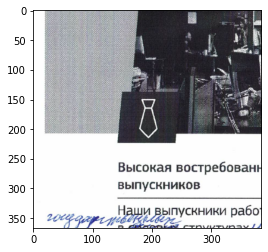

In [7]:
image = load_image(PATHS[0])
plt.imshow(image)
plt.show()

In [8]:
def central_crop_image(image, epsilon=0.1):
    TARGET_SIZE = tf.constant(100, dtype=tf.float32)

    image_size = tf.cast(tf.minimum(*image.shape[:2]), tf.float32)
    crop_fraction = tf.minimum((TARGET_SIZE / image_size)+epsilon, tf.constant(1, dtype=tf.float32))
    cropped_image = tf.image.central_crop(image, crop_fraction)
    return tf.image.resize(cropped_image, (TARGET_SIZE, TARGET_SIZE))

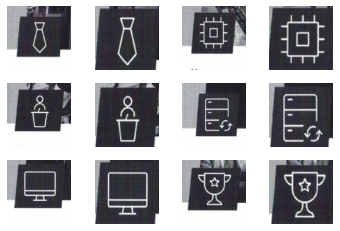

In [11]:
for i, path in enumerate(PATHS):
    img = load_image(path)
    img = central_crop_image(img)
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [41]:
def augment_image(image, lower=0., upper=3., max_delta=0.4, factor=1.):
    image = tf.image.adjust_saturation(
        image, tf.random.uniform((), minval=lower, maxval=upper))
    image = tf.image.adjust_brightness(
        image, tf.random.uniform((), minval=-max_delta, maxval=max_delta))
    image = tf.image.random_flip_left_right(image)
    image = tf.keras.layers.experimental.preprocessing.RandomRotation(factor)(
        tf.reshape(image, (1, 100, 100, 3)))
    return image

In [13]:
def get_labeled_image(path):

    def _get_label(path):
        str_label = tf.strings.split(path, sep=os.sep)[-2]
        return tf.strings.to_number(str_label, out_type=tf.int32)-1

    label = _get_label(path)
    image = load_image(path)
    image = central_crop_image(image)

    return (image, label)

In [42]:
def get_data(paths, counts=100, split=False):

    def get_augmented_image(path):
        image, label = get_labeled_image(path)
        image = augment_image(image)
        image = tf.reshape(image, (100, 100, 3))
        return [image, label]

    images = list()
    labels = list()
    data = list()

    paths = tf.random.shuffle(tf.repeat(paths, counts))
    size = len(paths)

    start_time = time.time()
    
    with ThreadPoolExecutor(8) as pool:
        data = list(pool.map(get_augmented_image, paths))

    for x, y in data:
        images.append(x)
        labels.append(y)

    tf.print("Loading data takes {:.3f}s".format(time.time()-start_time))

    if split:
        train_size = int(size*0.7)
        return (images[:train_size], labels[:train_size]), (images[train_size:], labels[train_size:])
    else:
        return images, labels

In [43]:
(train_images, train_labels), (test_images, test_labels) = get_data(PATHS, counts=200, split=True)

Loading data takes 31.281s


In [44]:
len(train_images), len(train_labels), len(test_images), len(test_labels)

(1680, 1680, 720, 720)

In [45]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.batch(60)
train_dataset

<BatchDataset shapes: ((None, 100, 100, 3), (None,)), types: (tf.float32, tf.int32)>

In [46]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(60)

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer((100, 100, 3)),
    tf.keras.layers.Conv2D(filters=20, kernel_size=3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(filters=20, kernel_size=5, strides=5, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(3, 3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(6, activation='softmax'),
], name='ArtWayClass')

model.summary()

Model: "ArtWayClass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 20)      560       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 10)        1810      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 20)          5020      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 20)          0         
_________________________________________________________________
flatten (Flatten)            (None, 20)                

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [21]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch == 0 or (epoch+1) % 10 == 0:
            tf.print('Epoch {:4d} - loss: {:.4f} - acc: {:.4f}, val_loss: {:.4f}, val_acc - {:.4f}'.format(
                epoch+1, logs['loss'], logs['accuracy'], logs['val_loss'], logs['val_accuracy']))

In [47]:
model.fit(
    train_dataset, 
    epochs=100,
    validation_data=test_dataset,
    callbacks=[CustomCallback()],
    verbose=0)

Epoch    1 - loss: 0.5200 - acc: 0.8595, val_loss: 0.2417, val_acc - 0.9292
Epoch   10 - loss: 0.2178 - acc: 0.9214, val_loss: 0.1010, val_acc - 0.9722
Epoch   20 - loss: 0.1591 - acc: 0.9423, val_loss: 0.0401, val_acc - 0.9889
Epoch   30 - loss: 0.1284 - acc: 0.9518, val_loss: 0.0506, val_acc - 0.9875
Epoch   40 - loss: 0.1267 - acc: 0.9560, val_loss: 0.0469, val_acc - 0.9875
Epoch   50 - loss: 0.1280 - acc: 0.9536, val_loss: 0.0319, val_acc - 0.9931
Epoch   60 - loss: 0.1048 - acc: 0.9613, val_loss: 0.0363, val_acc - 0.9917
Epoch   70 - loss: 0.1058 - acc: 0.9613, val_loss: 0.0375, val_acc - 0.9944
Epoch   80 - loss: 0.1049 - acc: 0.9583, val_loss: 0.0418, val_acc - 0.9903
Epoch   90 - loss: 0.0932 - acc: 0.9637, val_loss: 0.0476, val_acc - 0.9861
Epoch  100 - loss: 0.0829 - acc: 0.9708, val_loss: 0.0482, val_acc - 0.9847


In [48]:
model.save('models/{}-0.2.h5'.format(model.name))

In [49]:
test_image = load_image('test_image.png')
test_image = central_crop_image(test_image)
model.predict(tf.reshape(test_image, (1, 100, 100, 3)))

array([[3.0852850e-14, 4.1066548e-07, 1.2754415e-01, 1.6931423e-07,
        5.8985046e-05, 8.7239635e-01]], dtype=float32)

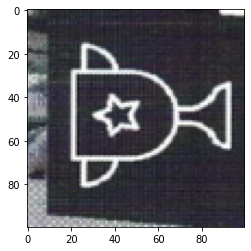

In [50]:
plt.imshow(test_image)

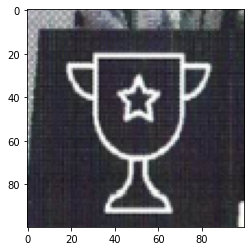

In [40]:
plt.imshow(test_image)